# Integrating Embeddings with Queries in an Information Retrieval System

## Objective

In this exercise, we will learn how to integrate embeddings with a query to enhance an Information Retrieval (IR) system. We will use both static and contextual embeddings to generate representations of queries and documents, compute their similarities, and rank the documents based on relevance to the query.

---

## Stages Covered

1. **Introduction to Pre-trained Transformer Models**
   - Load and use BERT for contextual embeddings.
   - Load and use Word2Vec for static embeddings.

2. **Generating Text Embeddings**
   - Generate embeddings for queries and documents using BERT.
   - Generate embeddings for queries and documents using Word2Vec.

3. **Computing Similarity Between Embeddings**
   - Compute cosine similarity between query and document embeddings.
   - Rank documents based on similarity scores.

4. **Integrating Embeddings with Queries**
   - Practical implementation of embedding-based retrieval for a given text corpus.

---

## Prerequisites

- TensorFlow
- Hugging Face's Transformers library
- Gensim library
- Scikit-learn library
- A text corpus in the `../data` folder

---

## Exercise

Follow the steps below to integrate embeddings with a query and enhance your IR system.



Step 0: Verify requirements:

* tensorflow
* transformers
* scikit-learn
* matplotlib
* seaborn

Step 1: Download dataset from Kaggle

URL: https://www.kaggle.com/datasets/zynicide/wine-reviews

In [1]:
import kaggle
import pandas as pd

kaggle.api.dataset_download_cli(dataset='zynicide/wine-reviews')

wine_df = pd.read_csv('data/winemag-data_first150k.csv')
print(wine_df.head())
corpus = wine_df['description']

Dataset URL: https://www.kaggle.com/datasets/zynicide/wine-reviews
License(s): CC-BY-NC-SA-4.0
wine-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
   Unnamed: 0 country                                        description  \
0           0      US  This tremendous 100% varietal wine hails from ...   
1           1   Spain  Ripe aromas of fig, blackberry and cassis are ...   
2           2      US  Mac Watson honors the memory of a wine once ma...   
3           3      US  This spent 20 months in 30% new French oak, an...   
4           4  France  This is the top wine from La Bégude, named aft...   

                            designation  points  price        province  \
0                     Martha's Vineyard      96  235.0      California   
1  Carodorum Selección Especial Reserva      96  110.0  Northern Spain   
2         Special Selected Late Harvest      96   90.0      California   
3                               Reserve      96   65

Step 2: Load a Pre-trained Transformer Model

Use the BERT model for generating contextual embeddings and Word2Vec for static embeddings.

In [2]:
import tensorflow as tf
import gensim.downloader as api
from transformers import BertTokenizer, TFBertModel
from concurrent.futures import ThreadPoolExecutor

# Load pre-trained Word2Vec model
word2vec_model = api.load('word2vec-google-news-300')

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

2024-07-14 14:15:35.407525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 14:15:35.769732: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 14:15:35.771617: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-14 14:15:36.198834: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-14 14:15:37.965052: W tensorflow/compiler/tf

Step 3: Generate Text Embeddings

Static Embeddings with Word2Vec

In [3]:
import numpy as np
import time

# serial approach
#def generate_word2vec_embeddings(texts):
#    if isinstance(texts, str):
#        texts = [texts]
#    embeddings = []
#    for text in texts:
#        tokens = text.lower().split()
#        word_vectors = [word2vec_model[word] for word in tokens if word in word2vec_model]
#        if word_vectors:
#            embeddings.append(np.mean(word_vectors, axis=0))
#        else:
#            embeddings.append(np.zeros(word2vec_model.vector_size))
#    return np.array(embeddings)

# parallel aproach

        
def generate_word2vec_embeddings(texts, model):
    if isinstance(texts, str):
        texts = [texts]

    def process_text(text):
        tokens = text.lower().split()
        word_vectors = [model[word] for word in tokens if word in model]
        if word_vectors:
            return np.mean(word_vectors, axis=0)
        else:
            return np.zeros(model.vector_size)

    with ThreadPoolExecutor() as executor:
        embeddings = list(executor.map(process_text, texts))

    return np.array(embeddings)

start_time = time.time()
# change corpus size here
word2vec_embeddings = generate_word2vec_embeddings(corpus[:1000], word2vec_model)
end_time = time.time()
elapsed_time = end_time - start_time

print("Word2Vec Embeddings:", word2vec_embeddings)
print("Word2Vec Shape:", word2vec_embeddings.shape)
print(f"Elapsed time for generate_word2vec_embeddings: {elapsed_time} seconds")

# --- Time checks
# elmnt_num  |  time (s)
# 1000       |  0.122196
# 2000       | 

Word2Vec Embeddings: [[ 0.01978664  0.03414721 -0.00884628 ... -0.01573336  0.06626587
  -0.02784729]
 [ 0.0016861  -0.00124741 -0.00065494 ... -0.04453754  0.06408358
   0.03221512]
 [-0.01758194  0.06408924  0.02408564 ... -0.04092503  0.09110224
   0.01769352]
 ...
 [ 0.01005607  0.02371788  0.01270689 ...  0.00072506  0.0994018
  -0.00354214]
 [-0.04502139 -0.01401487  0.00770204 ... -0.0113406   0.0971892
   0.0698083 ]
 [ 0.05029713  0.00299766  0.02918937 ... -0.02717868  0.01937866
   0.06121271]]
Word2Vec Shape: (1000, 300)
Elapsed time for generate_word2vec_embeddings: 1.231180191040039 seconds


Contextual Embeddings with BERT

In [4]:
#serial approach
#def generate_bert_embeddings(texts):
#    embeddings = []
#    for text in texts:
#        inputs = tokenizer(text, return_tensors='tf', padding=True, truncation=True)
#        outputs = model(**inputs)
#        embeddings.append(outputs.last_hidden_state[:, 0, :])  # Use [CLS] token representation
#    return np.array(embeddings).transpose(0,2,1)

# parallel approach


def generate_embedding(text):
    try:
        max_length = model.config.max_position_embeddings
        tokens = tokenizer.tokenize(text)
        if len(tokens) > max_length:
            tokens = tokens[:max_length]
            text = tokenizer.convert_tokens_to_string(tokens)
        
        inputs = tokenizer(text, return_tensors='tf', padding='max_length', truncation=True, max_length=max_length)
        outputs = model(**inputs)
        embedding = outputs.last_hidden_state[:, 0, :].numpy()  # Use [CLS] token representation
        #print(f"Embedding shape: {embedding.shape}")
        return embedding
    except Exception as e:
        print(f"Error processing text '{text}': {e}")
        default_embedding = np.zeros((1,model.config.hidden_size))  # Assuming a default size matching the model's hidden size
        print(f"Returning default embedding of shape: {default_embedding.shape}")
        return default_embedding

def generate_bert_embeddings(texts, max_workers=4):
    if isinstance(texts, str):
        texts = [texts]
    embeddings = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(generate_embedding, texts))
        # Filter out None results
        valid_results = [res for res in results if res is not None]
        if not valid_results:
            raise ValueError("No valid embeddings were generated.")
        embeddings.extend(valid_results)
    #embeddings_array = np.array(embeddings)
    embeddings_array = np.vstack(embeddings)
    print("embeddings_array: ", embeddings_array)
    print(f"Embeddings array shape: {embeddings_array.shape}")
    #embeddings_stack = np.stack(embeddings)
    #print("embeddings_stack: ", embeddings_stack)
    #print(f"Embeddings stack shape: {embeddings_array.shape}")  # Add this line to print the shape
    return embeddings_array

start_time = time.time()

# change corpus size here
bert_embeddings = generate_bert_embeddings(corpus[:1000])
end_time = time.time()
elapsed_time = end_time - start_time

# change corpus size here
print("corpus shape: ", corpus[:1000].shape)
print("BERT Embeddings:", bert_embeddings)
print("Word2Vec Shape:", bert_embeddings.shape)
print(f"Elapsed time for generate_bert_embeddings: {elapsed_time} seconds")

# --- Time checks
# elmnt_num  |  time (s)
# 1000       |  213.863
# 2000       | 

embeddings_array:  [[ 0.11967471 -0.48856765  0.36452943 ... -0.4368054   0.11976154
   0.18947849]
 [-0.05186658 -0.3650651   0.6474592  ... -0.31474593  0.05560172
   0.5154337 ]
 [-0.73173153  0.35088524 -0.01913854 ... -0.03388381  0.22656603
   0.30798095]
 ...
 [-0.3508076  -0.17860682  0.07678379 ... -0.04831259  0.414316
   0.42155796]
 [-0.09701809 -0.13228095  0.29377276 ... -0.08387621  0.12906367
   0.52626574]
 [-0.76645327  0.25537887  0.04604271 ... -0.18621103  0.33776098
   0.48638424]]
Embeddings array shape: (1000, 768)
corpus shape:  (1000,)
BERT Embeddings: [[ 0.11967471 -0.48856765  0.36452943 ... -0.4368054   0.11976154
   0.18947849]
 [-0.05186658 -0.3650651   0.6474592  ... -0.31474593  0.05560172
   0.5154337 ]
 [-0.73173153  0.35088524 -0.01913854 ... -0.03388381  0.22656603
   0.30798095]
 ...
 [-0.3508076  -0.17860682  0.07678379 ... -0.04831259  0.414316
   0.42155796]
 [-0.09701809 -0.13228095  0.29377276 ... -0.08387621  0.12906367
   0.52626574]
 [-0.76

Step 4: Compute Similarity Between Embeddings

Use the scikit-learn library.

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

# serial aproach for cosin sim
start_time = time.time()
word2vec_similarity = cosine_similarity(word2vec_embeddings)
end_time = time.time()
elapsed_time = end_time - start_time
print("Word2Vec Cosine Similarity:\n", word2vec_similarity)
print(f"Elapsed time for word2vec_similarity: {elapsed_time} seconds")

# --- Time checks
# elmnt_num  |  time (s)
# 1000       |  0.03234
# 2000       | 

# Cosine similarity between BERT embeddings
start_time = time.time()
# change corpus size here
bert_similarity = cosine_similarity(bert_embeddings.reshape(1000,768))
end_time = time.time()
elapsed_time = end_time - start_time
print("BERT Cosine Similarity:\n", bert_similarity)
print(f"Elapsed time for bert_similarity: {elapsed_time} seconds")

# --- Time checks
# elmnt_num  |  time (s)
# 1000       |  0.050683
# 2000       | 

Word2Vec Cosine Similarity:
 [[1.         0.8253629  0.80511177 ... 0.8419296  0.7819131  0.77259463]
 [0.8253629  1.0000004  0.7915441  ... 0.8054646  0.8462608  0.84858894]
 [0.80511177 0.7915441  0.99999976 ... 0.7692924  0.74307513 0.75645304]
 ...
 [0.8419296  0.8054646  0.7692924  ... 0.99999976 0.80588186 0.7845779 ]
 [0.7819131  0.8462608  0.74307513 ... 0.80588186 0.99999994 0.794002  ]
 [0.77259463 0.84858894 0.75645304 ... 0.7845779  0.794002   1.0000005 ]]
Elapsed time for word2vec_similarity: 0.00890970230102539 seconds
BERT Cosine Similarity:
 [[0.99999994 0.9255339  0.85955054 ... 0.8542755  0.8943703  0.7732071 ]
 [0.9255339  1.0000002  0.83921105 ... 0.8649401  0.92164874 0.8356073 ]
 [0.85955054 0.83921105 0.99999976 ... 0.8528121  0.8442376  0.83112955]
 ...
 [0.8542755  0.8649401  0.8528121  ... 0.99999976 0.91954637 0.84242046]
 [0.8943703  0.92164874 0.8442376  ... 0.91954637 1.         0.861027  ]
 [0.7732071  0.8356073  0.83112955 ... 0.84242046 0.861027   1.000

Step 5: Compare Contextual and Static Embeddings

Analyze and compare the similarity results from both BERT and Word2Vec embeddings.

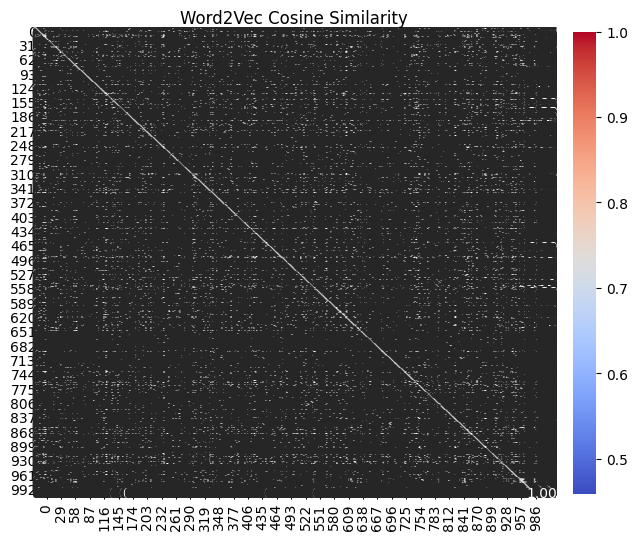

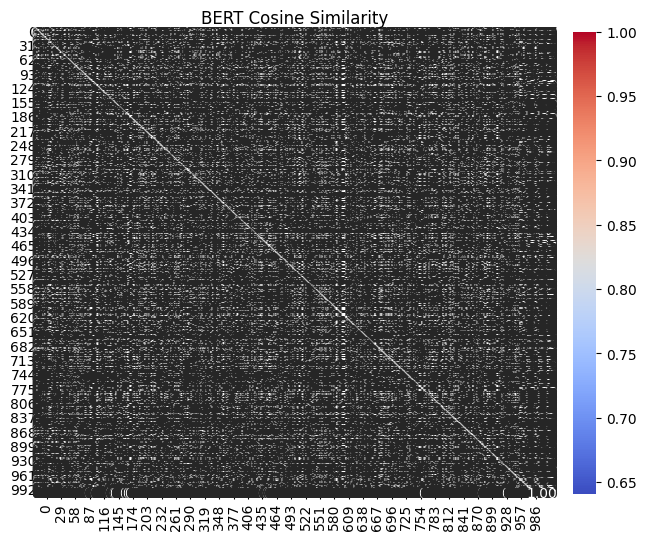

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_similarity_matrix(matrix, title, figsize=(8, 6), annotation=True):
    plt.figure(figsize=figsize)
    sns.heatmap(matrix, annot=annotation, cmap='coolwarm', fmt='.2f')
    plt.title(title)
    plt.show()

plot_similarity_matrix(word2vec_similarity, "Word2Vec Cosine Similarity")
plot_similarity_matrix(bert_similarity, "BERT Cosine Similarity")

Step 6: Applying to Corpus

Summary

So far, in this exercise, you learned how to:

* Load a pre-trained transformer model (BERT) and a static embedding model (Word2Vec).
* Generate text embeddings using these models.
* Compute cosine similarity between embeddings.
* Compare the similarity results from both contextual and static embeddings.

Now you have a practical understanding of how transformers and embeddings can be used in Information Retrieval systems.

Let's integrate query search.

Step 7: Generate Embeddings for the Query

Generate embeddings for the query using the same model used for the documents.

In [8]:
# Input you query text
# userInput = input("escribe tu frase de busqueda: ")
userInput = "dog shoe umbrella cat"

# Generate embeddings for the input
input_word2vec_embeddings = generate_word2vec_embeddings(userInput,word2vec_model)
input_bert_embeddings = generate_bert_embeddings(userInput)

print("input w2v shape: ", input_word2vec_embeddings.shape)
print("input bert shape: ", input_bert_embeddings.shape)

embeddings_array:  [[-5.52324176e-01  2.28668764e-01 -1.87490597e-01  7.49489218e-02
   1.61957890e-01  8.88432786e-02 -1.36320665e-03  2.29976788e-01
  -4.48839009e-01  1.45307243e-01 -1.85579032e-01 -2.30907440e-01
  -7.34767392e-02  4.61271226e-01 -3.66915643e-01 -1.02584139e-01
  -4.29471582e-01  5.12172818e-01  3.65376882e-02 -1.70564130e-02
   5.24340905e-02 -2.59347022e-01 -6.35182738e-01 -2.52417415e-01
  -1.00022480e-01 -1.69516116e-01  2.89239101e-02 -9.05724764e-02
   1.33089319e-01  2.66511261e-01  2.10499227e-01  3.18711288e-02
  -6.19334690e-02 -3.48038673e-01 -1.32834315e-02 -2.41039649e-01
   3.44361395e-01 -2.28285015e-01 -2.02051029e-01 -1.08820438e-01
   1.24850556e-01  6.05632812e-02  5.47596157e-01  2.47118101e-02
   1.55455455e-01 -3.66919041e-01 -2.46925235e+00  4.60021049e-02
  -9.59334075e-02 -2.36777216e-01  6.12619221e-02  4.50165980e-02
   3.54039490e-01 -7.22839125e-03  8.42149630e-02  3.52737814e-01
   2.48209462e-02  5.73473155e-01  2.03569859e-01 -1.8957

Step 8: Compute Similarity Between Query and Documents

Compute the similarity between the query embedding and each document embedding.

(1000, 300)
(1, 300)
(1, 1000)


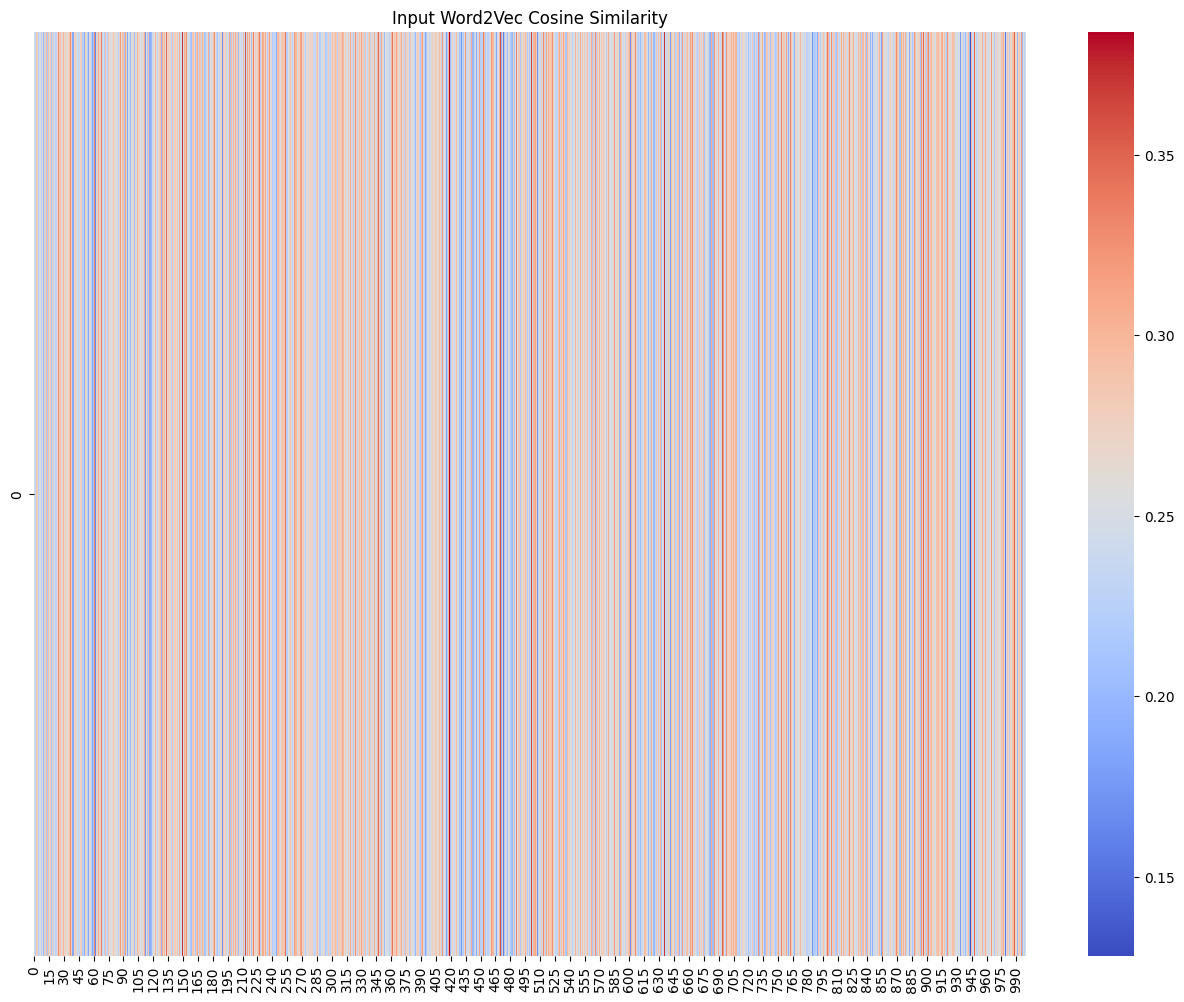

In [9]:
# Compute similarity for the input
input_word2vec_similarity = cosine_similarity(input_word2vec_embeddings,word2vec_embeddings)

print(word2vec_embeddings.shape)
print(input_word2vec_embeddings.shape)
print(input_word2vec_similarity.shape)

plot_similarity_matrix(input_word2vec_similarity, "Input Word2Vec Cosine Similarity", figsize=(16, 12), annotation=False)


(1000, 768)
(1, 768)
(1000, 1)


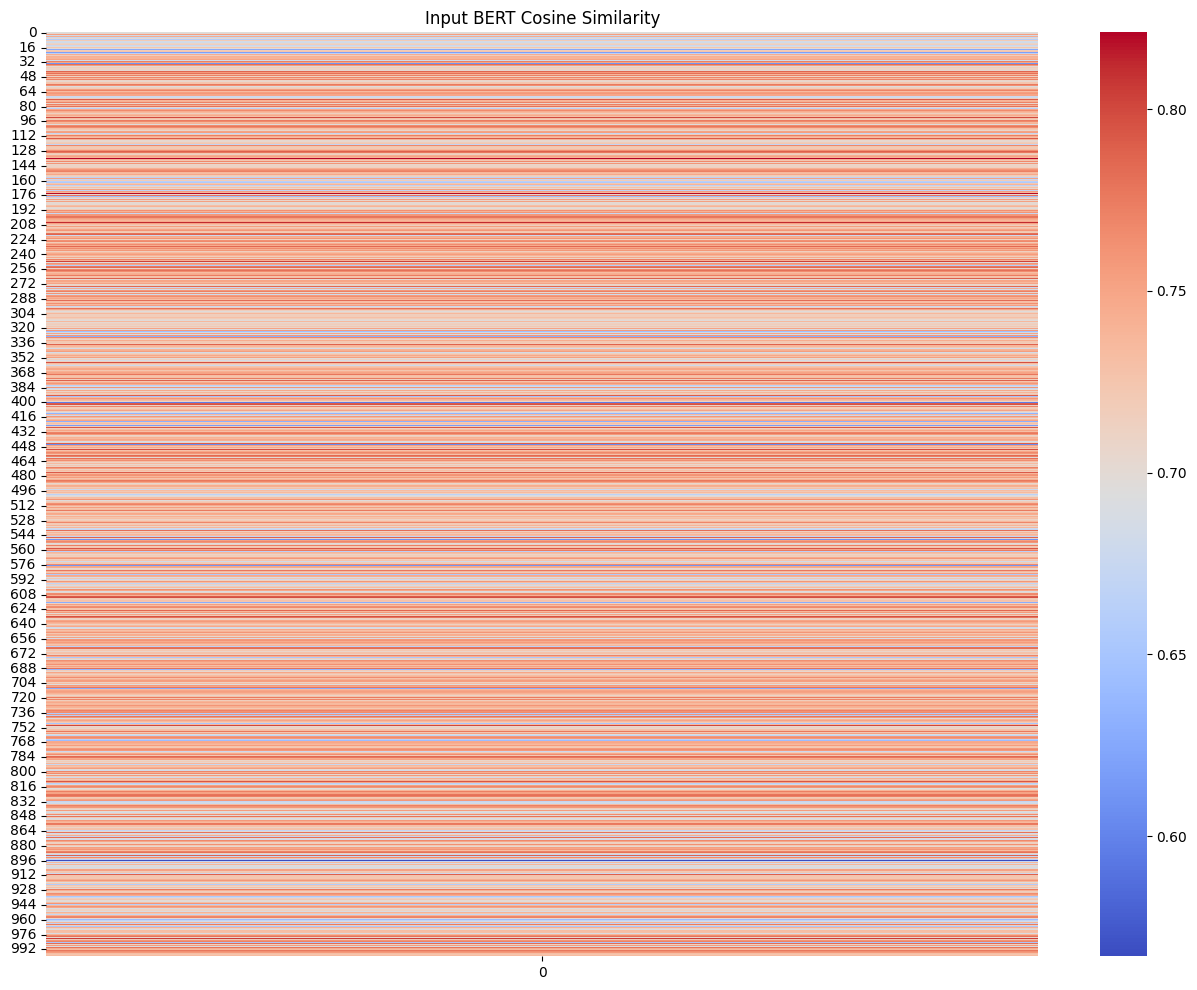

In [10]:
# change reshape to meet input shape here (this change with input size)
input_bert_similarity = cosine_similarity(bert_embeddings,input_bert_embeddings)

print(bert_embeddings.shape)
print(input_bert_embeddings.shape)
print(input_bert_similarity.shape)

# Plot similarity matrices

plot_similarity_matrix(input_bert_similarity, "Input BERT Cosine Similarity", figsize=(16, 12), annotation=False)

Step 9: Retrieve and Rank Documents Based on Similarity Scores

Retrieve and rank the documents based on their similarity scores to the query.

In [11]:
# Flatten the matrix of similarity into a list of tuples
#print(input_word2vec_similarity)
word2vec_similarity_list = [
    (i, j, input_word2vec_similarity[i, j])
    for i in range(input_word2vec_similarity.shape[0])
    for j in range(i + 1, input_word2vec_similarity.shape[1])
]

# Sort based on similarity scores
sorted_word2vec_sim_list = sorted(word2vec_similarity_list, key=lambda x: x[2], reverse=True)

#for i, value in enumerate(input_word2vec_similarity[0]):
#    print(f"Similarity: {input_word2vec_similarity[0][i]}, Designation: {wine_df[:1000].loc[i, 'designation']}")


similarities_and_designations = []
for i, value in enumerate(input_word2vec_similarity[0]):
    designation = wine_df[:1000].loc[i, 'designation']
    similarities_and_designations.append((value, designation))

# Sort the list of tuples by similarity value
similarities_and_designations.sort(reverse=True)

top_10_similarities_and_designations = similarities_and_designations[:10]

# Print the top 10 results
for similarity, designation in top_10_similarities_and_designations:
    print(f"Similarity: {similarity}, Designation: {designation}")




Similarity: 0.38399481773376465, Designation: Riserva
Similarity: 0.3717252016067505, Designation: nan
Similarity: 0.37067392468452454, Designation: Soul Shaker Cass Vineyard
Similarity: 0.3652982711791992, Designation: Paderewski Vineyard
Similarity: 0.36226531863212585, Designation: nan
Similarity: 0.35394519567489624, Designation: Bien Nacido Vineyard
Similarity: 0.35357290506362915, Designation: Fausoni
Similarity: 0.3495200276374817, Designation: Juel
Similarity: 0.34866616129875183, Designation: Starr Ridge Vineyard Estate
Similarity: 0.34858816862106323, Designation: Sun Chase Vineyard


In [12]:
# Flatten the matrix of similarity into a list of tuples
#for i, value in enumerate(input_bert_similarity):
#    print(f"Similarity: {input_bert_similarity[i][0]}, Designation: {wine_df[:1000].loc[i, 'designation']}")

similarities_and_designations = []
for i, value in enumerate(input_bert_similarity):
    designation = wine_df[:1000].loc[i, 'designation']
    similarities_and_designations.append((value[0], designation))

# Sort the list of tuples by similarity value
similarities_and_designations.sort(reverse=True)

# Get the top 10 similarities and their corresponding designations
top_10_similarities_and_designations = similarities_and_designations[:10]

# Print the top 10 results
for similarity, designation in top_10_similarities_and_designations:
    print(f"Similarity: {similarity}, Designation: {designation}")


Similarity: 0.8211472034454346, Designation: Mustang Springs
Similarity: 0.8197413682937622, Designation: Héritages Elevé en Foudres de Chêne
Similarity: 0.8114029169082642, Designation: nan
Similarity: 0.8058596253395081, Designation: Cannubi
Similarity: 0.8024614453315735, Designation: Limited Selection
Similarity: 0.8005175590515137, Designation: Château de Rouffiac Séduction
Similarity: 0.800006628036499, Designation: Nature
Similarity: 0.7983033657073975, Designation: Senza Solfiti Aggiunti
Similarity: 0.7972152233123779, Designation: nan
Similarity: 0.7971886992454529, Designation: Manna
